In [1]:
import requests
import csv
import time
from collections import Counter
import pandas as pd
import datetime as dt #only if you want to analyze the date created feature
import json 
from types import SimpleNamespace
import sys
from nltk.tokenize import TreebankWordTokenizer
from textblob import TextBlob
from tabulate import tabulate
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

## Creating two dataframes:
    1. One for the mental illness group users
    2. One for the control group users

In [2]:
df_anx_1 = pd.read_csv("dataset/reddit-posts-mental.csv", index_col=0)
df_anx_2 = pd.read_csv("dataset/reddit-posts-anxiety.csv", index_col=0)
df_anx_3 = pd.read_csv("dataset/reddit-posts-unrelated.csv", index_col=0)
df_anxiety_group = pd.concat([df_anx_1, df_anx_2, df_anx_3])
df_control_group = pd.read_csv("dataset/reddit-control.csv", index_col=0)

## Word-clouds based on Word Frequency

In [3]:
def get_tokens_for_cloud(df):
    comment_words = '' 
    count = 0
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in df['title']: 
        if count%5000==0:
            print("Title", count)
        count +=1
        # typecaste each val to string 
        val = str(val) 

        tokens = [word.lower() for word in val.split() \
                  if word.lower() not in stopwords\
                  and not word == "nan"\
                 and len(word)>4]
        
        comment_words += " ".join(tokens)+" "
        
    return comment_words

def gen_word_cloud(tokens):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(tokens) 

    # plot the WordCloud image                        
    plt.figure(figsize = (6, 6), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()  

Title 0
Title 5000


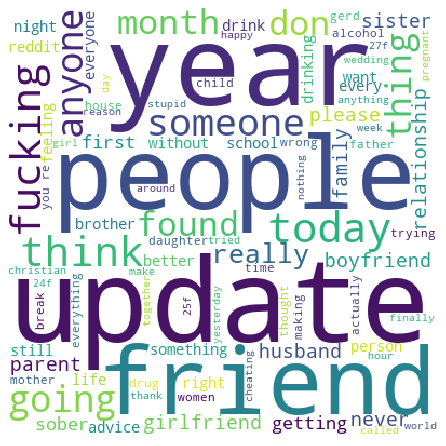

In [4]:
# WORD CLOUD BASED ON WORD FREQUENCY - NOT REALLY USEFUL
gen_word_cloud(get_tokens_for_cloud(df_control_group))

Title 0
Title 5000
Title 10000
Title 15000
Title 20000
Title 25000
Title 30000
Title 35000
Title 40000
Title 45000
Title 50000


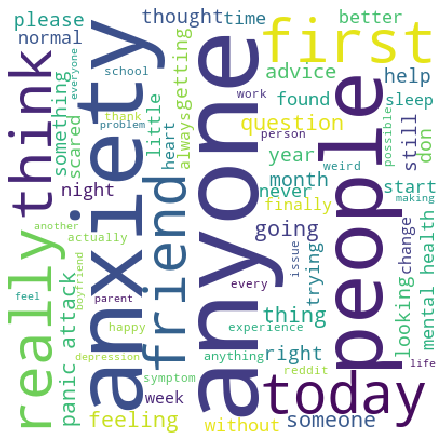

In [5]:
# WORD CLOUD BASED ON WORD FREQUENCY - NOT REALLY USEFUL
gen_word_cloud(get_tokens_for_cloud(df_anxiety_group))

## Wordcloud based on Odds Score (Relevance to the prediction)
For this we needed to run a base-line Logistic Regression model based on Bag-of-Words

In [6]:
anxiety_odds_df = pd.read_csv("dataset/reddit-posts-anxiety.csv", index_col=0)
control_odds_df = pd.read_csv("dataset/reddit-control.csv", index_col=0)
anxiety_odds_df['label'] = 1
control_odds_df['label'] = 0
df_input = pd.concat([anxiety_odds_df, control_odds_df])
df_input = df_input.sample(frac=1) # SHUFFLE THE ROWS

# INPUT: TITLE OF EACH POST
# OUTPUT: ANXIOUS / NOT ANXIOUS (1 / 0)
from sklearn.model_selection import train_test_split
X = list(df_input['title'])
y = list(df_input['label'])
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size = 0.3, random_state = 0) 

In [7]:
def clean_text(raw_review):
    # Remove HTML
    review_text = BeautifulSoup(raw_review, 'lxml').get_text() 

    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    
    # Convert to lower case, split into individual words
    words = letters_only.lower().split()   

    # Remove stop words (use of sets makes this faster)
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops and len(w) > 4]                             

    return ( " ".join( meaningful_words )) 

def apply_cleaning_function_to_series(X):
    print('Cleaning data')
    cleaned_X = []
    for element in X:
        cleaned_X.append(clean_text(element))
    print ('Cleaning finished')
    return cleaned_X

# CLEAN BOTH TRAIN AND TEST TITLES
X_train_clean = apply_cleaning_function_to_series(X_train)
X_test_clean = apply_cleaning_function_to_series(X_test)

Cleaning data


/Users/mallikapriyakhullar/anaconda3/envs/nlu/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/mallikapriyakhullar/anaconda3/envs/nlu/lib/python3.6/site-packages/bs4/__init__.py:314: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Cleaning finished
Cleaning data
Cleaning finished


## Running LogisticRegression baseline based on simple CountVectorizer

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


cv = CountVectorizer(binary=True)
cv.fit(X_train_clean)
X = cv.transform(X_train_clean)
X_test = cv.transform(X_test_clean)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.7056367432150313
Accuracy for C=0.05: 0.7676978553805276
Accuracy for C=0.25: 0.8079331941544885
Accuracy for C=0.5: 0.811159612829759
Accuracy for C=1: 0.8128677168343139


In [10]:
final_model = LogisticRegression(C=1)
final_model.fit(X, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
pred_y = final_model.predict(X_test)
print ("Final Accuracy: %s" % accuracy_score(y_test, pred_y))

Final Accuracy: 0.8128677168343139


In [36]:
def grey_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return "hsl(0, 0%%, %d%%)" % 0

def show_cloud(words):
    d = {}
    for a, x in words:
        d[a] = x

    import matplotlib.pyplot as plt
    from wordcloud import WordCloud

    wordcloud = WordCloud()
    wordcloud.prefer_horizontal = 1
    wordcloud.width = 800
    wordcloud.height= 800
    wordcloud.background_color = 'white'
    wordcloud.generate_from_frequencies(frequencies=d)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3), interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [37]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}


pos_words = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:100]

neg_words = sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:100]


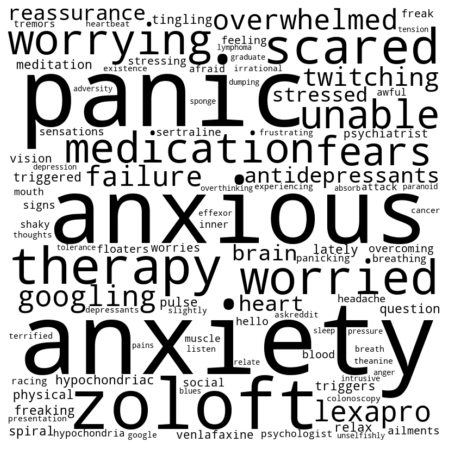

In [38]:
show_cloud(pos_words)

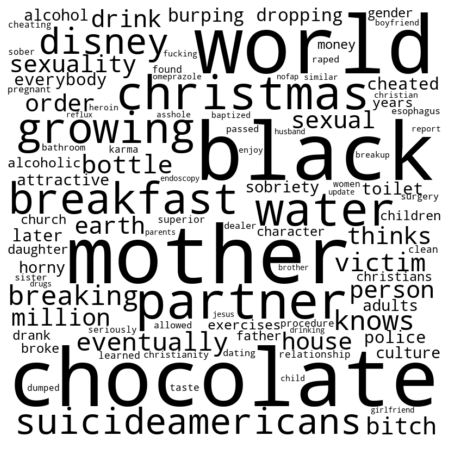

In [39]:
show_cloud(neg_words)

## Number of posts in non-anxiety forums by each group

In [43]:
anx_group = pd.read_csv("dataset/reddit-posts-unrelated.csv", index_col=0)
control_group = pd.read_csv("dataset/reddit-control.csv", index_col=0)

In [62]:
anx_counter = Counter()
control_counter = Counter()
for sub in anx_group['sub']:
    anx_counter[sub] += 1

for sub in control_group['sub']:
    control_counter[sub] += 1

In [63]:
# for word,occurences in anx_counter.items():
#     print("Number of posts in: r/%s has %s posts" %(word,occurences))

print(pd.DataFrame(anx_counter.most_common(20)).head(20))

                      0     1
0             AskReddit  1196
1     NoStupidQuestions   278
2                Advice   257
3                 NoFap   225
4   relationship_advice   222
5                   aww   220
6      unpopularopinion   190
7        Showerthoughts   184
8                  cats   161
9                 trees   152
10          emetophobia   151
11             insomnia   151
12                  ibs   141
13        relationships   140
14             BreakUps   137
15                 dpdr   135
16                Drugs   133
17            teenagers   132
18                memes   130
19         Christianity   125


In [64]:
print(pd.DataFrame(control_counter.most_common(20)).head(20))

                      0    1
0                  rant  874
1                  GERD  867
2                Advice  864
3      unpopularopinion  858
4          stopdrinking  834
5         relationships  832
6   relationship_advice  815
7              BreakUps  747
8                 Drugs  668
9     NoStupidQuestions  547
10         Christianity  381
11                NoFap  291
12                  ibs  154
13            teenagers  151
14       Showerthoughts  118
15                trees   64
16            AskReddit   11
17                  aww    1
